In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loader import *
from models import *
from utils import *
from plotting import *

In [3]:
im_size_width, im_size_height, radius1, radius2 = 256, 256, 0.17e-6, 0.3e-6
plankton1 = stationary_spherical_plankton(im_size_height, im_size_width, 
                                          radius1, label=0)
plankton2 = stationary_spherical_plankton(im_size_height, im_size_width, 
                                          radius2, label=1)

gradient_amp = 1
microscope = plankton_brightfield(im_size_height, im_size_width, gradient_amp)

no_of_plankton1 = lambda: np.random.randint(10, 20)
no_of_plankton2 = lambda: np.random.randint(10, 20)

sample = plankton1**no_of_plankton1 + plankton2**no_of_plankton2

noise_amp, norm_min, norm_max = 2, -0.2, 1.2
image = create_image(noise_amp, sample, microscope, norm_min, norm_max)
label_function = get_target_image
batch_function = create_custom_batch_function(image, 
                                              outputs=[0], 
                                              function_img=[Normalize_image])


In [49]:
from deeptrack.generators import ContinuousGenerator
generator = ContinuousGenerator(
    image,
    get_target_image,
    batch_function,
    batch_size=8,
    min_data_size=128,
    max_data_size=512)

no_of_inputs, no_of_outputs = 1, 3
model = generate_unet(None, None, no_of_inputs, no_of_outputs)
model = train_model_early_stopping(model, generator, patience=10, 
                                   epochs=100, steps_per_epoch=10)

Generating 130 / 128 samples before starting training
Epoch 1/100
10/10 [==============================] - 1s 65ms/step - loss: 0.0029
Epoch 2/100
10/10 [==============================] - 1s 75ms/step - loss: 0.0028
Epoch 3/100
10/10 [==============================] - 1s 66ms/step - loss: 0.0025: 0s - loss: 0
Epoch 4/100
10/10 [==============================] - 1s 63ms/step - loss: 0.0021
Epoch 5/100
10/10 [==============================] - 1s 63ms/step - loss: 0.0014
Epoch 6/100
10/10 [==============================] - 1s 62ms/step - loss: 9.4129e-04
Epoch 7/100
10/10 [==============================] - 1s 63ms/step - loss: 6.0515e-04
Epoch 8/100
10/10 [==============================] - 1s 63ms/step - loss: 4.4487e-04
Epoch 9/100
10/10 [==============================] - 1s 63ms/step - loss: 4.7688e-04
Epoch 10/100
10/10 [==============================] - 1s 64ms/step - loss: 4.1581e-04
Epoch 11/100
10/10 [==============================] - 1s 66ms/step - loss: 3.1871e-04
Epoch 12/100
10

In [10]:
# save_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\models\\frame-by-frame.keras'
# model.save(save_path_model)

In [4]:
load_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\Raw_output\\models\\frame-by-frame.keras'
model = keras.models.load_model(load_path_model, custom_objects={'softmax_categorical':softmax_categorical})

In [5]:
folder_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\From erik\\raw output'
im_stack = get_image_stack(
    outputs=[0], 
    folder_path=folder_path, 
    frame_im0=20, 
    im_size_width=1280, 
    im_size_height=1024,
    im_resize_width=1280, 
    im_resize_height=1024,
    function_img=[])

# plot_image_stack(im_stack)
# plot_prediction(model=model, im_stack=im_stack)
# plt.imshow(model.predict(im_stack)[0,:,:,1]>0.999, cmap='gray')

In [6]:
positions2 = extract_positions(
    no_of_frames=50, 
    outputs=[0], 
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=1280, 
    im_size_height=1024,
    im_resize_width=1280, 
    im_resize_height=1024,
    model=model, 
    layer=2, 
    value_threshold=0.99,
    function_img=[])

positions1 = extract_positions(
    no_of_frames=50, 
    outputs=[0], 
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=1280, 
    im_size_height=1024,
    im_resize_width=1280, 
    im_resize_height=1024,
    model=model, 
    layer=1, 
    value_threshold=0.99,
    function_img=[])

In [7]:
list_of_plankton1 = assign_positions_to_planktons(positions1, max_dist=5, threshold = 5, extrapolate=True)
list_of_plankton1 = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton1)
list_of_plankton1 = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton1, min_distance=0)

plankton_track1, plankton_dont_track1 = split_plankton(percentage_threshold=0.07, list_of_plankton=list_of_plankton1)

list_of_plankton2 = assign_positions_to_planktons(positions2, max_dist=20, threshold = 5, extrapolate=True)
list_of_plankton2 = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton2)
list_of_plankton2 = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton2, min_distance=0)

plankton_track2, plankton_dont_track2 = split_plankton(percentage_threshold=0.1, list_of_plankton=list_of_plankton2)

Since the kernel freezes when trying to plot and save all images in one go we divide it up into parts and go at it 10 images at a time.

In [14]:
im_size_width=1280
im_size_height=1024
color_plankton_track = 'b'
color_plankton_dont_track = 'r'
save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\segmentation'
frame_name = 'track'
file_type = '.jpg'
save_images = 1
frame_im0 = 40
no_of_frames = 10
pixel_length_ratio=1
x_axis_label='pixels'
y_axis_label='pixels'

positions_track = extract_positions_from_list(plankton_track1)[max(frame_im0-5,0):min(frame_im0 + no_of_frames + 1,51),:]
positions_dont_track = extract_positions_from_list(plankton_track2)[max(frame_im0-5,0):min(frame_im0 + no_of_frames + 1,51),:]

list_paths = os.listdir(folder_path)

for i, j in enumerate(range(frame_im0, frame_im0 + no_of_frames)):
    fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
    im = cv2.imread(folder_path +'\\' + list_paths[j])
    dims = im.shape

    scale_height = dims[0]/im_size_height
    scale_width = dims[1]/im_size_width

    if frame_im0 == 0:
        ax.plot(scale_width*positions_track[max(i-5,0):i+1, 1::2],scale_height*positions_track[max(i-5,0):i+1, 0::2], c=color_plankton_track,linewidth=1)
        ax.scatter(scale_width*positions_track[i,1::2], scale_height*positions_track[i,0::2], s=100, marker='.', facecolor='none', edgecolors=color_plankton_track)

        ax.plot(scale_width*positions_dont_track[max(i-5,0):i+1, 1::2],scale_height*positions_dont_track[max(i-5,0):i+1, 0::2], c=color_plankton_dont_track,linewidth=1)
        ax.scatter(scale_width*positions_dont_track[i,1::2], scale_height*positions_dont_track[i,0::2], s=100, marker='.', facecolor='none', edgecolors=color_plankton_dont_track)
    else:
    
        ax.plot(scale_width*positions_track[i:i+6, 1::2],scale_height*positions_track[i:i+6, 0::2], c=color_plankton_track,linewidth=1)
        ax.scatter(scale_width*positions_track[i+5,1::2], scale_height*positions_track[i+5,0::2], s=100, marker='.', facecolor='none', edgecolors=color_plankton_track)

        ax.plot(scale_width*positions_dont_track[i:i+6, 1::2],scale_height*positions_dont_track[i:i+6, 0::2], c=color_plankton_dont_track,linewidth=1)
        ax.scatter(scale_width*positions_dont_track[i+5,1::2], scale_height*positions_dont_track[i+5,0::2], s=100, marker='.', facecolor='none', edgecolors=color_plankton_dont_track)

    
    ax.imshow(im, cmap="gray")

    
    locs, labels = plt.xticks()
    labels = [int(float(item)*pixel_length_ratio) for item in locs]
    plt.xticks(locs[1:-1], labels[1:-1])
    plt.xlabel(x_axis_label)
    plt.xlabel(y_axis_label)
    plt.title('Planktons')
    
    if save_images: 
        plt.savefig(save_path + '\\' + frame_name + '%0{}d'.format(len(str(no_of_frames))) % j + file_type)
        plt.close(fig)
    else:
        
        plt.show()

In [ ]:
# plot_and_save_track(no_of_frames=50,
#                     plankton_track=plankton_track1,
#                     plankton_dont_track=plankton_track2,
#                     folder_path=folder_path,
#                     frame_im0=0,
#                     save_images=1,
#                     show_plankton_track = True,
#                     show_plankton_dont_track = 1,
#                     show_numbers_track = 0,
#                     show_numbers_dont_track = 0,
#                     show_numbers_specific_plankton = False,
#                     show_specific_plankton = False,
#                     specific_plankton = None,
#                     im_size_width=1280, 
#                     im_size_height=1024,
#                     color_plankton_track = 'b',
#                     color_plankton_dont_track = 'r',
#                     color_specific_plankton = 'w',
#                     save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\segmentation',
#                     frame_name = 'track',
#                     file_type = '.jpg')

In [17]:
# Make_video(frame_im0=0,
#            folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\b3 report', 
#            save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\b3 report.avi', 
#            fps=7, 
#            no_of_frames=50)

[ 0.  0. 18.  9.  4.  9.  4.  4.  2.  3.  1.  3.  1.  4.  2.  2.  1.  0.
  0.  1.  0.  0.  1.  0.  2.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  2.  1.  0.  0.  0.  2. 16.]
[ 0.  0. 24.  5. 11. 10.  5.  5.  3.  8.  3.  3.  2.  5.  3.  2.  1.  3.
  2.  1.  2.  3.  1.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.  2.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  2. 13.]


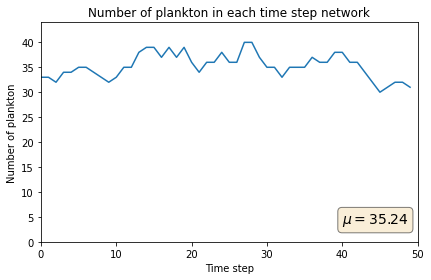

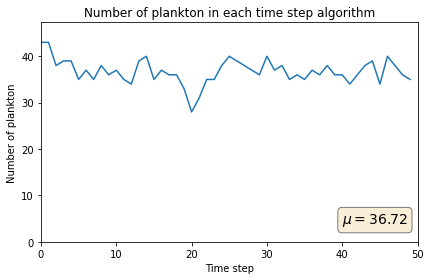

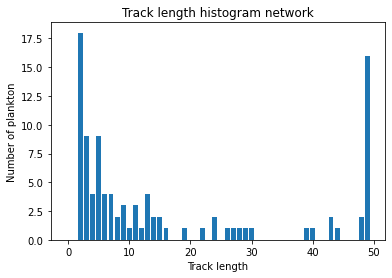

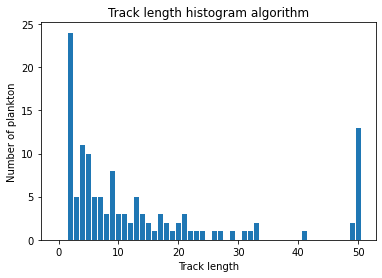

In [7]:
import xml.etree.ElementTree as ET

def plot_statistics(found_plankton_at_timestep, title):
    cropped_finds = found_plankton_at_timestep[np.nonzero(found_plankton_at_timestep)[0]]

    ax = plt.figure()
    plt.plot(range(len(cropped_finds)), cropped_finds)
    plt.xlabel('Time step')
    plt.ylabel('Number of plankton')
    plt.title(title)
    plt.tight_layout()
    mu = np.mean(cropped_finds)
    
    plt.axis([0, len(cropped_finds), 0, max(cropped_finds)*1.1])
    
    textstr = r'$\mu=%.2f$' % (mu, )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.8, 0.25, textstr, fontsize=14,
            verticalalignment='top', bbox=props)
    
def get_found_plankton_at_timestep(plankton_track):
    no_timesteps = len(plankton_track[list(plankton_track.keys())[0]].positions)
    found_plankton_at_timestep = np.zeros(no_timesteps)

    for plankton in plankton_track:
        plankton = np.array(plankton_track[plankton].positions[:,0], dtype=float)
        where_list = np.where(np.isfinite(plankton))
        for i in where_list[0]:
            found_plankton_at_timestep[i] += 1
    return found_plankton_at_timestep

def get_found_plankton_from_xml(path, no_timesteps, var_str):
    tree = ET.parse(path)
    root = tree.getroot()


    found_plankton_at_timestep = np.zeros(no_timesteps)

    for particle in root.iter():
        my_dict = particle.attrib
        if var_str in my_dict:
            found_plankton_at_timestep[int(float(my_dict[var_str]))] += 1
    return found_plankton_at_timestep


def plot_bars(track_durations, title):
    plt.figure()
    plt.bar(range(len(track_durations)), track_durations)
    
    plt.xlabel('Track length')
    plt.ylabel('Number of plankton')
    plt.title(title)



def get_track_durations(plankton_track):
    no_of_timesteps = len(plankton_track[list(plankton_track.keys())[0]].positions)
    track_durations = np.zeros(no_of_timesteps)
    for plankton in plankton_track:
        plankton = np.array(plankton_track[plankton].positions[:,0], dtype=float)
        where_list = np.where(np.isfinite(plankton))
        track_start = np.min(where_list)
        track_end = np.max(where_list)

        track_durations[track_end-track_start] += 1
    return track_durations


found_plankton_at_timestep = get_found_plankton_at_timestep(plankton_track)     
plot_statistics(found_plankton_at_timestep, 'Number of plankton in each time step network')


path = "E:\\Documents\\Master\\exjobb\\software\\Tracking\\raw output_Tracks.xml"
no_timesteps = 51
found_plankton_at_timestep = get_found_plankton_from_xml(path, no_timesteps, 't')
plot_statistics(found_plankton_at_timestep, 'Number of plankton in each time step algorithm')


track_durations = get_track_durations(plankton_track)
plot_bars(track_durations, 'Track length histogram network')
print(track_durations)

track_durations = get_found_plankton_from_xml(path, no_timesteps, 'nSpots')
plot_bars(track_durations, 'Track length histogram algorithm')
print(track_durations)

In [25]:
track_durations

array([ 0.,  0., 24.,  5., 11., 10.,  5.,  5.,  3.,  8.,  3.,  3.,  2.,
        5.,  3.,  2.,  1.,  3.,  2.,  1.,  2.,  3.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  1.,  0.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 13.])